In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.io.wavfile as wave
import numpy.fft
from IPython.display import Audio

In [2]:
# returns sampling frequency and audio data in range [-1, 1]. prints audio length and sample rate
def read_wav_audio(audio_relative_path):
    # fs is sample rate, audio_data is data from a .wav file
    fs, audio_data = wave.read(audio_relative_path)

    # audio length in seconds
    length = len(audio_data) / fs

    print("Audio length:", round(length, 2), "seconds")
    print("Sample rate:", fs, "Hz")

    # convert dtype to float32. works on common data types specified in
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html
    dtype = audio_data.dtype
    if dtype != np.float32:
        type_info = np.iinfo(dtype)
        audio_data = np.interp(
            audio_data, [type_info.min, type_info.max], [-1, 1])

    return fs, audio_data

In [3]:
audio_base_path = 'audio/'
audio_file_name = 'test.wav'

In [4]:
fs, audio_data = read_wav_audio(audio_base_path + audio_file_name)

Audio length: 18.0 seconds
Sample rate: 44100 Hz


/home/dogg/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [5]:
Audio(audio_data, rate=fs)

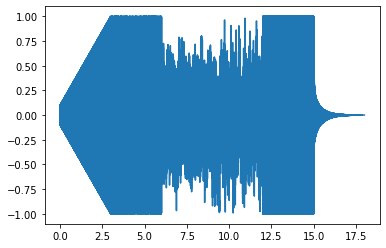

In [6]:
# plot audio over time
t = np.linspace(0, len(audio_data) / fs, len(audio_data))
plt.plot(t, audio_data)

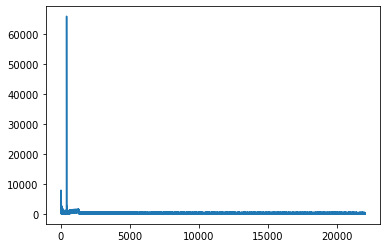

In [7]:
# fw is fourier transform of audio (r in rfft means real input)
fw = np.fft.rfft(audio_data)
w = np.linspace(0, fs / 2, len(fw))

# plot fourier transform of the whole audio
plt.plot(w, np.abs(fw))

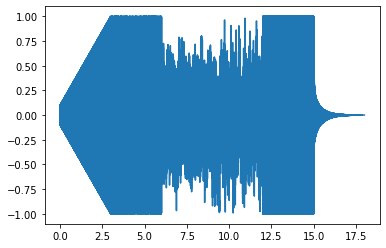

In [8]:
# plot inverse fourier transform to see everything is correct
inv_fw = np.fft.irfft(fw)
t = np.linspace(0, len(audio_data) / fs, len(inv_fw))

plt.plot(t, inv_fw)

In [9]:
# n_width is window width and n_overlap is window overlap (in samples)
def get_window_generator(signal, n_width, n_overlap):
    index = 0
    original_length = len(signal)

    while True:
        start_pos = (n_width - n_overlap) * index
        stop_pos = start_pos + n_width  # last index is excluded

        if start_pos > original_length:
            break

        # pad signal with zeros if stop_pos has exceeded signal length
        if stop_pos > original_length:
            delta = stop_pos - original_length
            signal = np.pad(signal, (0, delta), 'constant')

        chunk = signal[start_pos:stop_pos]
        window = abs(np.fft.rfft(chunk))

        yield window

        index = index + 1

In [10]:
def get_matrix(audio_data, n_width=1024, n_overlap=512, eps=1e-5):
    windows = get_window_generator(audio_data, n_width, n_overlap)

    # create array which will have fourier transforms in it
    fts = []
    for w in windows:
        fts.append(w)

    # transpose matrix so its columns are fourier transforms (for easier plotting)
    fts = np.array(fts).T

    # rescale matrix
    minimum = fts.min()
    maximum = fts.max()

    for i in range(fts.shape[0]):
        fts[i] = np.interp(fts[i], [minimum, maximum], [eps, 1])
        fts[i] = 10*np.log10(fts[i])

    return fts

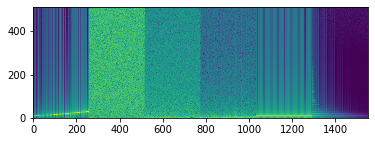

In [11]:
# plot current figure, doesn't look like much yet
fts = get_matrix(audio_data)
plt.imshow(fts, origin='lower')

In [12]:
def plot_specgram(signal, fs,
                  n_width=1024, n_overlap=512, eps=1e-5, figsize=(15, 7), colorbar=True, labels=True):
    plt.figure(figsize=figsize)

    fts = get_matrix(signal, n_width, n_overlap, eps)

    # compute x and y max values
    x_max = fts.shape[1] * (n_width - n_overlap) / fs
    y_max = fs / 2

    # plot spectrogram specifying additional parameters
    plt.imshow(fts,
               origin='lower',
               aspect='auto',
               extent=[0, x_max, 0, y_max],
               interpolation='nearest',
               cmap='viridis')  # useful cmaps: inferno, magma, viridis

    if colorbar:
        cbar = plt.colorbar(None, use_gridspec=True)

    if labels:
        plt.xlabel("Time (sec)")
        plt.ylabel("Frequency (Hz)")

        if colorbar:
            cbar.ax.set_ylabel('Power (dB)')

    plt.show()

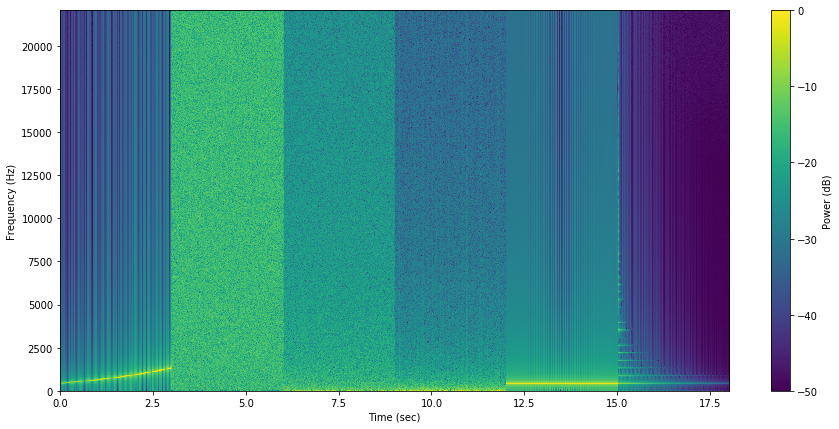

In [13]:
# define epsilon - number to which the darkest color maps
eps = 1e-5
n_width = 1024
n_overlap = 0  # n_width // 2

plot_specgram(audio_data, fs, n_width, n_overlap, eps)

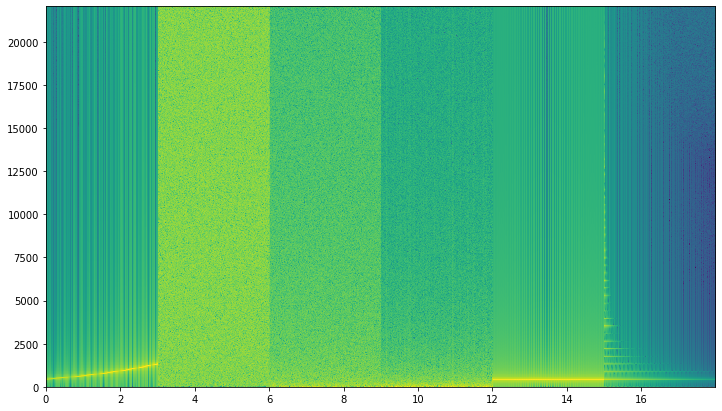

In [14]:
plt.figure(figsize=(12, 7))

# plot spectrogram with matplotlib library and confirm that our result is similar
# additional parameter can be: window=plt.mlab.window_none
plt.specgram(audio_data, NFFT=n_width, Fs=fs, noverlap=n_overlap, aspect='auto', window=plt.mlab.window_none)
plt.show()